In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from utils.sampling import mnist_iid, mnist_noniid
from model.update import LocalUpdate
from model.Net import CNNMnist
from model.Fed import FedAvg
from model.test import test_img, test_for_deep_ensemble
import copy
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class args_parser:
    def __init__(self, dictionary):
        for key in dictionary:
            setattr(self, key, dictionary[key])

In [2]:

#FedAvg IID
args = args_parser({
  'epochs':50,
  'num_users':100,
  'frac':0.1,
  'local_ep':20,
  'local_bs':10,
  'bs':128,
  'lr':0.01,
  'momentum':0.5,
  'split' :'user',
  'mu':0,
  'kernel_num':9,
  'kernel_sizes' : '3,4,5',
  'norm' :'batch_norm',
  'num_filters':32,
  'max_pool' :'True',
  'num_classes':10,
  'num_channels':1,
  'gpu':0,
  'stopping_rounds':10,
  'verbose': True,
  'seed':1,
  'all_clients': False,
})

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape
print('img_size',img_size)
net_glob = CNNMnist(args=args).to(args.device)
print(net_glob)
net_glob.train()
w_glob = net_glob.state_dict()
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_accuacy = []
brier_scores = []

if args.all_clients:
    print("Aggregation over all clients")
    w_locals = [w_glob for i in range(args.num_users)]

for iter in range(args.epochs):

    loss_locals = []
    if not args.all_clients:
        w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss, _ = local.train(net=copy.deepcopy(net_glob).to(args.device))
        if args.all_clients:
            w_locals[idx] = copy.deepcopy(w)
        else:
            w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

    # testing
    net_glob.eval()
    acc_test, loss_test, brier_score_test, prob_test = test_img(net_glob, dataset_test, args)
    print("Testing accuracy: {:.2f}".format(acc_test))
    brier_scores.append(brier_score_test)
    test_accuacy.append(acc_test.item())
    # print(test_accuacy)

df = pd.DataFrame(brier_scores)
df.to_csv('brier_scores_fedavg_iid.csv'.format(brier_scores), index = False)
df = pd.DataFrame(test_accuacy)
df.to_csv('FedAvg_test_accuacy_B_{}_E_{}_iid.csv'.format(args.local_bs, args.local_ep), index=False)


img_size torch.Size([1, 28, 28])
CNNMnist(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Round   0, Average loss 0.264
brier_score 0.0068626060041645535
Testing accuracy: 95.59
Round   1, Average loss 0.046
brier_score 0.00492808493800605
Testing accuracy: 96.95
Round   2, Average loss 0.032
brier_score 0.004120176254265612
Testing accuracy: 97.42
Round   3, Average loss 0.026
brier_score 0.00347998947896579
Testing accuracy: 97.75
Round   4, Average loss 0.018
brier_score 0.0031378630804169403
Testing accuracy: 98.01
Round   5, Average loss 0.019
brier_score 0.002813196100750032
Testing accuracy: 98.22
Round   6, Average loss 0.016
brier_score 0.0027213028072321207
Testing accuracy: 98.30
Round   7, Average loss 0.016
brier_score 0.0025022835253806124
Testing accuracy: 98.42
Round   8, A

In [4]:

#FedAvg non-IID
args = args_parser({
  'epochs':50,
  'num_users':100,
  'frac':0.1,
  'local_ep':20,
  'local_bs':10,
  'bs':128,
  'lr':0.01,
  'momentum':0.5,
  'split' :'user',
  'mu':0,
  'kernel_num':9,
  'kernel_sizes' : '3,4,5',
  'norm' :'batch_norm',
  'num_filters':32,
  'max_pool' :'True',
  'num_classes':10,
  'num_channels':1,
  'gpu':0,
  'stopping_rounds':10,
  'verbose': True,
  'seed':1,
  'all_clients': False,
})

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_noniid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape
print('img_size',img_size)
net_glob = CNNMnist(args=args).to(args.device)
print(net_glob)
net_glob.train()
w_glob = net_glob.state_dict()
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_accuacy = []
brier_scores = []

if args.all_clients:
    print("Aggregation over all clients")
    w_locals = [w_glob for i in range(args.num_users)]

for iter in range(args.epochs):

    loss_locals = []
    if not args.all_clients:
        w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss, _ = local.train(net=copy.deepcopy(net_glob).to(args.device))
        if args.all_clients:
            w_locals[idx] = copy.deepcopy(w)
        else:
            w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

    # testing
    net_glob.eval()
    acc_test, loss_test, brier_score_test, prob_test = test_img(net_glob, dataset_test, args)
    print("Testing accuracy: {:.2f}".format(acc_test))
    brier_scores.append(brier_score_test)
    test_accuacy.append(acc_test.item())
    # print(test_accuacy)

df = pd.DataFrame(brier_scores)
df.to_csv('brier_scores_fedavg_noniid.csv'.format(brier_scores), index = False)
df = pd.DataFrame(test_accuacy)
df.to_csv('FedAvg_test_accuacy_B_{}_E_{}_noniid.csv'.format(args.local_bs, args.local_ep), index=False)


img_size torch.Size([1, 28, 28])
CNNMnist(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Round   0, Average loss 0.039
brier_score 0.10047737852096557
Testing accuracy: 18.41
Round   1, Average loss 0.018
brier_score 0.08049381439208984
Testing accuracy: 43.12
Round   2, Average loss 0.015
brier_score 0.07502060037612915
Testing accuracy: 42.65
Round   3, Average loss 0.013
brier_score 0.03884662714958191
Testing accuracy: 74.05
Round   4, Average loss 0.014
brier_score 0.031228794627189638
Testing accuracy: 79.76
Round   5, Average loss 0.012
brier_score 0.029913624887466427
Testing accuracy: 79.32
Round   6, Average loss 0.008
brier_score 0.027219579277038573
Testing accuracy: 83.06
Round   7, Average loss 0.007
brier_score 0.01431589303135872
Testing accuracy: 90.71
Round   8, Average 

In [5]:

#FedProx IID
args = args_parser({
  'epochs':50,
  'num_users':100,
  'frac':0.1,
  'local_ep':20,
  'local_bs':10,
  'bs':128,
  'lr':0.01,
  'momentum':0.5,
  'split' :'user',
  'mu':0.01,
  'kernel_num':9,
  'kernel_sizes' : '3,4,5',
  'norm' :'batch_norm',
  'num_filters':32,
  'max_pool' :'True',
  'num_classes':10,
  'num_channels':1,
  'gpu':0,
  'stopping_rounds':10,
  'verbose': True,
  'seed':1,
  'all_clients': False,
})

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape
print('img_size',img_size)
net_glob = CNNMnist(args=args).to(args.device)
print(net_glob)
net_glob.train()
w_glob = net_glob.state_dict()
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_accuacy = []
brier_scores = []

if args.all_clients:
    print("Aggregation over all clients")
    w_locals = [w_glob for i in range(args.num_users)]

for iter in range(args.epochs):

    loss_locals = []
    if not args.all_clients:
        w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss, _ = local.train(net=copy.deepcopy(net_glob).to(args.device))
        if args.all_clients:
            w_locals[idx] = copy.deepcopy(w)
        else:
            w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

    # testing
    net_glob.eval()
    acc_test, loss_test, brier_score_test, prob_test = test_img(net_glob, dataset_test, args)
    print("Testing accuracy: {:.2f}".format(acc_test))
    brier_scores.append(brier_score_test)
    test_accuacy.append(acc_test.item())
    # print(test_accuacy)

df = pd.DataFrame(brier_scores)
df.to_csv('brier_scores_fedprox_iid.csv'.format(brier_scores), index = False)
df = pd.DataFrame(test_accuacy)
df.to_csv('FedProx_test_accuracy_B_{}_E_{}_iid.csv'.format(args.local_bs, args.local_ep), index=False)


img_size torch.Size([1, 28, 28])
CNNMnist(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Round   0, Average loss 0.272
brier_score 0.007418491859100759
Testing accuracy: 95.18
Round   1, Average loss 0.051
brier_score 0.00505191283793789
Testing accuracy: 96.83
Round   2, Average loss 0.034
brier_score 0.003930863546867112
Testing accuracy: 97.57
Round   3, Average loss 0.025
brier_score 0.0033346891274370523
Testing accuracy: 97.89
Round   4, Average loss 0.020
brier_score 0.003196203917507191
Testing accuracy: 98.08
Round   5, Average loss 0.017
brier_score 0.0029141789529109918
Testing accuracy: 98.19
Round   6, Average loss 0.015
brier_score 0.0027171378516479268
Testing accuracy: 98.29
Round   7, Average loss 0.016
brier_score 0.0025670359307229927
Testing accuracy: 98.42
Round   8, 

In [6]:

#FedProx non-IID
args = args_parser({
  'epochs':50,
  'num_users':100,
  'frac':0.1,
  'local_ep':20,
  'local_bs':10,
  'bs':128,
  'lr':0.01,
  'momentum':0.5,
  'split' :'user',
  'mu':0.01,
  'kernel_num':9,
  'kernel_sizes' : '3,4,5',
  'norm' :'batch_norm',
  'num_filters':32,
  'max_pool' :'True',
  'num_classes':10,
  'num_channels':1,
  'gpu':0,
  'stopping_rounds':10,
  'verbose': True,
  'seed':1,
  'all_clients': False,
})

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_noniid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape
print('img_size',img_size)
net_glob = CNNMnist(args=args).to(args.device)
print(net_glob)
net_glob.train()
w_glob = net_glob.state_dict()
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_accuacy = []
brier_scores = []

if args.all_clients:
    print("Aggregation over all clients")
    w_locals = [w_glob for i in range(args.num_users)]

for iter in range(args.epochs):

    loss_locals = []
    if not args.all_clients:
        w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss, _ = local.train(net=copy.deepcopy(net_glob).to(args.device))
        if args.all_clients:
            w_locals[idx] = copy.deepcopy(w)
        else:
            w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

    # testing
    net_glob.eval()
    acc_test, loss_test, brier_score_test, prob_test = test_img(net_glob, dataset_test, args)
    print("Testing accuracy: {:.2f}".format(acc_test))
    brier_scores.append(brier_score_test)
    test_accuacy.append(acc_test.item())
    # print(test_accuacy)

df = pd.DataFrame(brier_scores)
df.to_csv('brier_scores_fedprox_noniid.csv'.format(brier_scores), index = False)
df = pd.DataFrame(test_accuacy)
df.to_csv('FedProx_test_accuracy_B_{}_E_{}_noniid.csv'.format(args.local_bs, args.local_ep), index=False)


img_size torch.Size([1, 28, 28])
CNNMnist(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Round   0, Average loss 0.053
brier_score 0.08339017219543457
Testing accuracy: 21.96
Round   1, Average loss 0.022
brier_score 0.056873273754119866
Testing accuracy: 61.94
Round   2, Average loss 0.012
brier_score 0.04637844588279724
Testing accuracy: 66.08
Round   3, Average loss 0.015
brier_score 0.030552467892169956
Testing accuracy: 80.07
Round   4, Average loss 0.010
brier_score 0.031323030309677126
Testing accuracy: 76.78
Round   5, Average loss 0.008
brier_score 0.029415339736938478
Testing accuracy: 78.11
Round   6, Average loss 0.010
brier_score 0.02725870145320892
Testing accuracy: 80.12
Round   7, Average loss 0.007
brier_score 0.03041648581981659
Testing accuracy: 80.48
Round   8, Average

In [2]:
from torch.utils.data import DataLoader, Dataset
from model.update import LocalUpdate, DatasetSplit
args = args_parser({
  'epochs':1,
  'num_users':10,
  'frac':1,
  'local_ep':1000,
  'local_bs':100,
  'bs':128,
  'lr':0.01,
  'momentum':0.5,
  'split' :'user',
  'mu':0,
  'kernel_num':9,
  'kernel_sizes' : '3,4,5',
  'norm' :'batch_norm',
  'num_filters':32,
  'max_pool' :'True',
  'num_classes':10,
  'num_channels':1,
  'gpu':0,
  'stopping_rounds':10,
  'verbose': True,
  'seed':1,
  'all_clients': True,
})

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
net_glob = CNNMnist(args=args).to(args.device)
net_glob.train()

dict_users = mnist_iid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape
print('img_size',img_size)

loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
test_accuacy = []
brier_scores = []

m = max(int(args.frac * args.num_users), 1)

# idxs_users = np.random.choice(range(args.num_users), m, replace=False)

models = [CNNMnist(args=args).to(args.device) for i in range(m)]
optimizers = [torch.optim.SGD(models[i].parameters(), lr=args.lr, momentum=args.momentum) for i in range(m)]
loss_funcs = [torch.nn.CrossEntropyLoss() for i in range(m)]
for iter in range(1,args.local_ep+1):

    for idx in range(m):
        net = models[idx]
        net.train()
        loss_func = loss_funcs[idx]
        optimizer = optimizers[idx]
        ldr_train = DataLoader(DatasetSplit(dataset_train, dict_users[idx]), batch_size=args.local_bs, shuffle=True)
        for batch_idx, (images, labels) in enumerate(ldr_train):
                images, labels = images.to(args.device), labels.to(args.device)
                net.zero_grad()
                log_probs = net(images)
                loss = loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
        # print('done_{}'.format(idx))

    if iter % 20 == 0:
        acc_test, loss_test, brier_score_test = test_for_deep_ensemble(models, dataset_test, args)
        brier_scores.append(brier_score_test)

df = pd.DataFrame(brier_scores)
df.to_csv('brier_scores_de_6000.csv'.format(brier_scores), index = False)

img_size torch.Size([1, 28, 28])
brier_score 0.004181809270591475
brier_score 0.0028036172087164595
brier_score 0.0023967586942472553
brier_score 0.002182600801821027
brier_score 0.002106954185819459
brier_score 0.0020268315897468553
brier_score 0.0020053308887575455
brier_score 0.001965001463367138
brier_score 0.0019341175112011534
brier_score 0.0019238117186356116
brier_score 0.001903422017193394
brier_score 0.0018931064465353034
brier_score 0.0019089819495931143
brier_score 0.001896067197961085
brier_score 0.0018698390913087786
brier_score 0.0019031317714320896
brier_score 0.0018672217369897174
brier_score 0.0018383771699190666
brier_score 0.0018623594925551025
brier_score 0.0018524969887609584
brier_score 0.001844570548455431
brier_score 0.00185555276503047
brier_score 0.0018565331716109117
brier_score 0.0018704621906819856
brier_score 0.001855823918753705
brier_score 0.001845297761069566
brier_score 0.0018385213453089252
brier_score 0.0018402940118781579
brier_score 0.001837094738

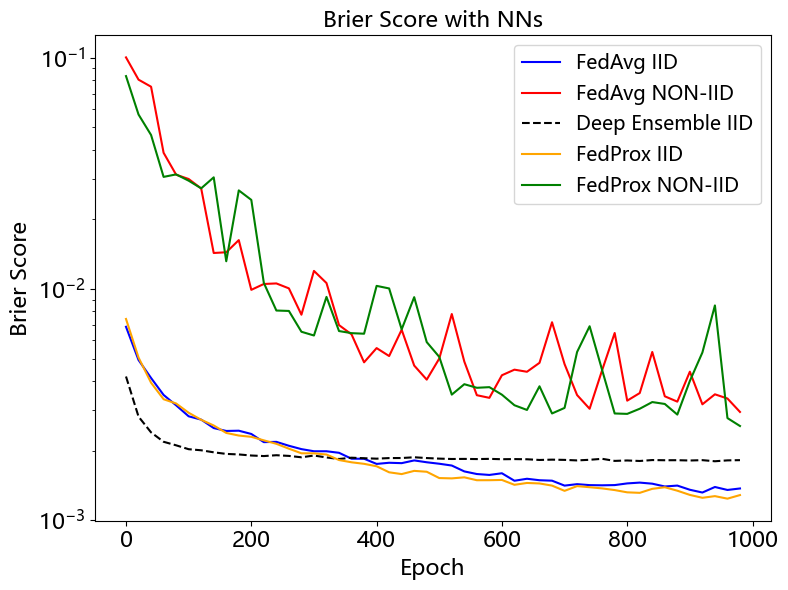

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # display “ - ”

brier_scores_iid = pd.read_csv('brier_scores_fedavg_iid.csv').to_numpy().tolist()
brier_scores_np_iid = np.array(brier_scores_iid)

brier_scores_noniid = pd.read_csv('brier_scores_fedavg_noniid.csv').to_numpy().tolist()
brier_scores_np_noniid = np.array(brier_scores_noniid)

brier_scores_de_6000 = pd.read_csv('brier_scores_de_6000.csv').to_numpy().tolist()
brier_scores_np_de_6000 = np.array(brier_scores_de_6000)
# brier_scores_np_de_6000 = brier_scores_np_de_6000[1:]


Fedprox_iid_brier_score = pd.read_csv('brier_scores_fedprox_iid.csv').to_numpy().tolist()
Fedprox_iid_np_brier_score = np.array(Fedprox_iid_brier_score)

Fedprox_noniid_brier_score = pd.read_csv('brier_scores_fedprox_noniid.csv').to_numpy().tolist()
Fedprox_noniid_np_brier_score = np.array(Fedprox_noniid_brier_score)

x_scale = np.arange(0, 1000, 20)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x_scale, brier_scores_np_iid, color='blue', label = 'FedAvg IID')
plt.plot(x_scale, brier_scores_np_noniid, color='red', label = 'FedAvg NON-IID')
plt.plot(x_scale, brier_scores_np_de_6000, color='black',linestyle='--', label = 'Deep Ensemble IID')
plt.plot(x_scale, Fedprox_iid_np_brier_score, color='orange', label = 'FedProx IID')
plt.plot(x_scale, Fedprox_noniid_np_brier_score, color='green', label = 'FedProx NON-IID')
plt.yscale("log")
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Brier Score', fontsize=16)
plt.title('Brier Score with NNs', fontsize=16)
plt.legend(fontsize=14)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.tight_layout()
plt.savefig('Brier Score.png', dpi=720)
plt.show()